In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures

In [2]:
import matplotlib.pyplot as plt

In [3]:
df_warbl = pd.read_csv('../Datasets/warblrb10k_public_wav/labels.csv')
df_ff101 = pd.read_csv('../Datasets/ff1010bird_wav/labels.csv')

In [4]:
# print(df_warbl.head())

In [5]:
# print(df_ff101.head())

In [6]:
from opensoundscape.torch.models.cnn import load_model
model = load_model('../microfaune_resnet18_train_augmentation_on/best.model')

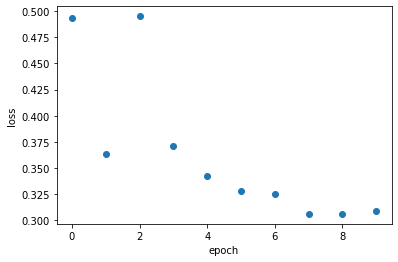

In [7]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [8]:
df_test = pd.read_csv('./separated_test_set_updated.csv')
df_test.dropna(inplace=True)
df_test['source2'].isnull().sum()

0

In [9]:
# df_orig_file = df_test[~df_test["Filename"].str.contains('_source')]
# df_orig_file.iloc[0]['Filename']

In [10]:
# resnet = model.network
from opensoundscape.annotations import categorical_to_one_hot
def convertToOneHot(df, colname):
    one_hot_labels, classes = categorical_to_one_hot(df[['Bird(s)?']].values)
    test_data = pd.DataFrame(index=df[colname],data=one_hot_labels,columns=classes)
    test_data.rename(columns={"y": "non-empty", "n": "empty"}, inplace=True)
    test_data = test_data[['empty', 'non-empty']]
    cols=[i for i in test_data.columns if i not in ["file"]]
    for col in cols:
        test_data[col]=pd.to_numeric(test_data[col])
    return test_data

In [11]:

# one_hot_labels, classes = categorical_to_one_hot(df_test[['Bird(s)?']].values)
# test_data = pd.DataFrame(index=df_test['Filename'],data=one_hot_labels,columns=classes)
# print(test_data.head())
# test_data.rename(columns={"y": "non-empty", "n": "empty"}, inplace=True)
# test_data = test_data[['empty', 'non-empty']]
# test_data.shape
# cols=[i for i in test_data.columns if i not in ["file"]]
# for col in cols:
#     test_data[col]=pd.to_numeric(test_data[col])

origTest = convertToOneHot(df_test, 'Filename')
source0Test = convertToOneHot(df_test, 'source0')
source1Test = convertToOneHot(df_test, 'source1')
source2Test = convertToOneHot(df_test, 'source2')
source3Test = convertToOneHot(df_test, 'source3')

In [12]:
# origTest

In [13]:
origTest['empty'].value_counts()

0    1480
1    1212
Name: empty, dtype: int64

In [14]:
def makePredictionAndSaveCSV(train_model, test_data, scoreFilename, predFilename):
    prediction_dataset = train_model.train_dataset.sample(n=0)
    prediction_dataset.augmentation_off()
    prediction_dataset.df = test_data
    
    valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                     binary_preds='single_target',
                                                                     activation_layer='softmax')
    
    valid_scores_df.to_csv(scoreFilename)
    valid_preds_df.to_csv(predFilename)
    return valid_labels_df

In [15]:
# #create a copy of the training dataset, sampling 0 of the training samples from it
# prediction_dataset = model.train_dataset.sample(n=0)
# #turn off augmentation on this dataset
# prediction_dataset.augmentation_off()
# #use the validation samples as test samples for the sake of illustration
# prediction_dataset.df = test_data

In [16]:
# prediction_dataset.df.columns

In [17]:
# valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
#                                                                  binary_preds='single_target',
#                                                                  activation_layer='softmax')

In [45]:
orig_labels = makePredictionAndSaveCSV(model, origTest, 'orig_scores_updated.csv', 'orig_predictions_updated.csv')
# label_one = makePredictionAndSaveCSV(model, source0Test, 'source0_scores_updated.csv', 'source0_predictions_updated.csv')
# label_one = makePredictionAndSaveCSV(model, source1Test, 'source1_scores_updated.csv', 'source1_predictions_updated.csv')
# label_one = makePredictionAndSaveCSV(model, source2Test, 'source2_scores_updated.csv', 'source2_predictions_updated.csv')
# label_one = makePredictionAndSaveCSV(model, source3Test, 'source3_scores_updated.csv', 'source3_predictions_updated.csv')

(2692, 2)


In [18]:
def getPredictionDf(inputDf):
    df = pd.read_csv(inputDf)
    df = df.rename(columns={'Unnamed: 0': 'Filename'})
    return df

In [19]:
orig_df = getPredictionDf('orig_predictions_updated.csv')
source0_df = getPredictionDf('source0_predictions_updated.csv')
source1_df = getPredictionDf('source1_predictions_updated.csv')
source2_df = getPredictionDf('source2_predictions_updated.csv')
source3_df = getPredictionDf('source3_predictions_updated.csv')

orig_sdf = getPredictionDf('orig_scores_updated.csv')
source0_sdf = getPredictionDf('source0_scores_updated.csv')
source1_sdf = getPredictionDf('source1_scores_updated.csv')
source2_sdf = getPredictionDf('source2_scores_updated.csv')
source3_sdf = getPredictionDf('source3_scores_updated.csv')

In [28]:
print((source0_df['Filename'] == df_test['source0']).value_counts())
print((source1_df['Filename'] == df_test['source1']).value_counts())
print((source2_df['Filename'] == df_test['source2']).value_counts())
print((source3_df['Filename'] == df_test['source3']).value_counts())
print((orig_df['Filename'] == df_test['Filename']).value_counts())

True    2692
dtype: int64
True    2692
dtype: int64
True    2692
dtype: int64
True    2692
dtype: int64
True    2692
Name: Filename, dtype: int64


In [29]:
print((source0_sdf['Filename'] == df_test['source0']).value_counts())
print((source1_sdf['Filename'] == df_test['source1']).value_counts())
print((source2_sdf['Filename'] == df_test['source2']).value_counts())
print((source3_sdf['Filename'] == df_test['source3']).value_counts())
print((orig_sdf['Filename'] == df_test['Filename']).value_counts())

True    2692
dtype: int64
True    2692
dtype: int64
True    2692
dtype: int64
True    2692
dtype: int64
True    2692
Name: Filename, dtype: int64


In [32]:
print((orig_df['non-empty'] == source0_df['non-empty']).value_counts())
print((orig_df['non-empty'] == source1_df['non-empty']).value_counts())
print((orig_df['non-empty'] == source2_df['non-empty']).value_counts())
print((orig_df['non-empty'] == source3_df['non-empty']).value_counts())

True     2060
False     632
Name: non-empty, dtype: int64
True     1730
False     962
Name: non-empty, dtype: int64
True     1591
False    1101
Name: non-empty, dtype: int64
True     1692
False    1000
Name: non-empty, dtype: int64


In [33]:
orig_df['new_non_empty'] = pd.Series()

for idx, row in orig_df.iterrows():
    scores = {1.0: 0, 0.0: 0}
    scores[orig_df.iloc[idx]['non-empty']] += 1
    scores[source0_df.iloc[idx]['non-empty']] += 1
    scores[source1_df.iloc[idx]['non-empty']] += 1
    scores[source2_df.iloc[idx]['non-empty']] += 1
    scores[source3_df.iloc[idx]['non-empty']] += 1
    print(scores)
    if(scores[1.0] > scores[0.0]):
        orig_df.iat[idx, 3] = 1
    else:
        orig_df.iat[idx, 3] = 0

/var/folders/km/7_v861mx0cb9fp42nvllkmt00000gn/T/ipykernel_83524/3872227234.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  orig_df['new_non_empty'] = pd.Series()


{1.0: 2, 0.0: 3}
{1.0: 3, 0.0: 2}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 4, 0.0: 1}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 4, 0.0: 1}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 

{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 4, 0.0: 1}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 4, 0.0: 1}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 1, 0.0: 4}
{1.0: 3, 0.0: 2}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 4, 0.0: 1}
{1.0: 3, 0.0: 2}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 5, 0.0: 0}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 4, 0.0: 

{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 3, 0.0: 2}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 4, 0.0: 1}
{1.0: 3, 0.0: 2}
{1.0: 2, 0.0: 3}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 4, 0.0: 1}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 5, 0.0: 0}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 3, 0.0: 2}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 5, 0.0: 0}
{1.0: 3, 0.0: 2}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 4, 0.0: 1}
{1.0: 2, 0.0: 

{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 3, 0.0: 2}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 

{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 4, 0.0: 1}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 3, 0.0: 2}
{1.0: 3, 0.0: 2}
{1.0: 1, 0.0: 4}
{1.0: 4, 0.0: 1}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 3, 0.0: 2}
{1.0: 5, 0.0: 0}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 5, 0.0: 0}
{1.0: 1, 0.0: 4}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 3, 0.0: 2}
{1.0: 0, 0.0: 5}
{1.0: 5, 0.0: 0}
{1.0: 2, 0.0: 3}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 0, 0.0: 5}
{1.0: 1, 0.0: 4}
{1.0: 2, 0.0: 3}
{1.0: 2, 0.0: 3}
{1.0: 4, 0.0: 1}
{1.0: 2, 0.0: 3}
{1.0: 4, 0.0: 1}
{1.0: 2, 0.0: 3}
{1.0: 3, 0.0: 2}
{1.0: 4, 0.0: 1}
{1.0: 0, 0.0: 

In [34]:
print((orig_df['non-empty'] == orig_df['new_non_empty']).value_counts())

True     1968
False     724
dtype: int64


In [40]:
# orig_sdf.head()

In [41]:
orig_sdf['new_non_empty_score'] = pd.Series()

for idx, row in orig_df.iterrows():
    orig_sdf.iat[idx, 3] = max(orig_sdf.iat[idx, 2], 
                           max(source0_sdf.iat[idx, 2],
                           max(source1_sdf.iat[idx, 2],
                           max(source2_sdf.iat[idx, 2], source3_sdf.iat[idx, 2]))))

/var/folders/km/7_v861mx0cb9fp42nvllkmt00000gn/T/ipykernel_83524/3733993619.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  orig_sdf['new_non_empty_score'] = pd.Series()


In [42]:
print((orig_sdf['non-empty'] == orig_sdf['new_non_empty_score']).value_counts())

False    1861
True      831
dtype: int64


In [43]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
# print(classification_report(valid_labels_df, valid_preds_df))

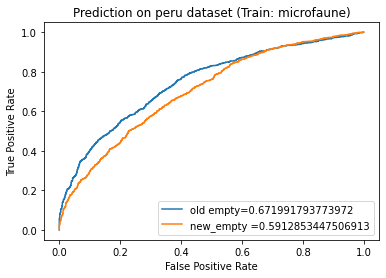

In [48]:
fpr, tpr, thresh = roc_curve(orig_labels['non-empty'],  orig_sdf['non-empty'])
auc = roc_auc_score(orig_labels['non-empty'],  orig_df['non-empty'])

fpr2, tpr2, thresh2 = roc_curve(orig_labels['non-empty'],  orig_sdf['new_non_empty_score'])
auc2 = roc_auc_score(orig_labels['non-empty'],  orig_df['new_non_empty'])

#create ROC curve
plt.plot(fpr,tpr,label="old empty="+str(auc))
plt.title('Prediction on peru dataset (Train: microfaune)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(fpr2, tpr2,label="new_empty ="+str(auc2))
plt.legend(loc=4)
plt.savefig('./AUC_curve_2600_peru_examples.jpg', format='jpg', transparent=False)
plt.show()